In [1]:
import numpy as np
from TDD.TDD import Ini_TDD,Clear_TDD,set_index_order,get_unique_table_num,set_root_of_unit,get_count,cont,renormalize,Slicing2
from TDD.TDD_Q import cir_2_tn,get_real_qubit_num,add_trace_line,add_inputs,add_outputs,gen_cir
from TDD.TN import Index,Tensor,TensorNetwork
import time
import random
from qiskit import QuantumCircuit
import cProfile
from IPython.display import display, HTML,Image
# from PIL import Image
from PIL import Image as PILImage

In [2]:
def simulate(cir,ini=False):
    tn,all_indexs = cir_2_tn(cir)
    tn.tensors=[ts for ts in tn.tensors if ts.name!='nu_q']
#     A=[ts.name for ts in tn.tensors]
#     print(A)
    if ini:
        var=[]
        for idx in all_indexs:
            if idx[0]=='x' and not '_' in idx:
                var.append('a'+idx[1:])
            var.append(idx)
            if idx[0]=='y' and not '_' in idx:
                var.append('b'+idx[1:])
#         print(var)
        for n in range(10):
            for k in range(50):
                s ='x'+str(n)+'_'+str(k)
                if not s in var:
                    var.append(s)
                s ='y'+str(n)+'_'+str(k)
                if not s in var:
                    var.append(s)               
                
        
        Ini_TDD(index_order=var)
        set_root_of_unit(2**3)

#     t_start=time.time()
    tdd=tn.cont()
#     print(time.time()-t_start)
#     print(tdd.weight)
#     print(tdd.node_number())
    return tdd

def change_index(tdd,x,y):
    """change the index from x to y"""
    
    idx_set = []
    key_2_index  = dict()
    index_2_key = dict()
    
    for idx in tdd.index_set:
        if idx.key[0]==x:
            idx_set.append(Index(y+idx.key[1:],idx.idx))
        else:
            idx_set.append(idx)
    
    for k in tdd.key_2_index:
        if isinstance(tdd.key_2_index[k],str) and tdd.key_2_index[k][0]==x:
            key_2_index[k]=y+tdd.key_2_index[k][1:]
        else:
            key_2_index[k]=tdd.key_2_index[k]
            
    for k in tdd.index_2_key:
        if isinstance(k,str) and k[0]==x:
            index_2_key[y+k[1:]]=tdd.index_2_key[k]
        else:
            index_2_key[k]=tdd.index_2_key[k]
    tdd.index_set=idx_set
    tdd.key_2_index=key_2_index
    tdd.index_2_key = index_2_key
    
    
def update_tdd(tdd,cir_head,cir_end):
#     cir_head.x([0,1,2])
#     cir_head.x([0,1,2])
#     cir_end.x([0,1,2])
#     cir_end.x([0,1,2])
    tdd1 = simulate(cir_head)
    change_index(tdd1,'x','a')
    change_index(tdd1,'y','x')

    tdd2 = simulate(cir_end)
    change_index(tdd2,'y','b')
    change_index(tdd2,'x','y')
    
    tdd_new=cont(tdd1,tdd)
    tdd_new=cont(tdd_new,tdd2)

    change_index(tdd_new,'a','x')
    change_index(tdd_new,'b','y')
    # tdd_new=renormalize(tdd_new)
    return tdd_new

def eliminate_control2(tdd,mode='x',level=0):
    
    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    if mode=='x':
        x=tdd.node.key-2*level
        the_map = get_downward_k_level_map(tdd,level,0)
    else:
        x=tdd.node.successor[0].key-2*level
        the_map = get_downward_k_level_map(tdd,level,1)
    
    q_c = int(tdd.key_2_index[x][1:])

    flag = False
    if the_map.level==-1:
        return tdd.self_copy(),cir_head,cir_end
    
    while the_map.level>-1:
        if x%2!=the_map.level%2:
            the_map=the_map.father
        else:
            flag = True
            temp_map=the_map
            the_map=the_map.father

    if flag == False:
        return tdd.self_copy(),cir_head,cir_end
    
    q = int(tdd.key_2_index[temp_map.level][1:])

    if tdd.key_2_index[temp_map.level][0]=='x':
        if temp_map.rotate>0:
            cir_head.cp(np.pi/4*(8-temp_map.rotate),q_c,q)
        if temp_map.x==1:
            cir_head.cx(q_c,q)
    else:
        if temp_map.x==1:
            cir_end.cx(q_c,q)
        if temp_map.rotate>0:
            cir_end.cp(np.pi/4*(8-temp_map.rotate),q_c,q)
    # print(cir_head.qasm())
    # print(cir_end.qasm())
    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new2,cir_head2,cir_end2 = eliminate_control2(tdd_new,mode,level)
    return tdd_new2,cir_head2&cir_head,cir_end&cir_end2
    
def eliminate_top_control2(tdd,level=0):
    tdd_new,cir_head,cir_end = eliminate_control2(tdd,'x',level)
    
    tdd_new2,cir_head2,cir_end2 = eliminate_control2(tdd_new,'y',level)
    

    if tdd_new2.map.level>-1:
        tdd_new3,cir_head3,cir_end3=eliminate_global_map(tdd_new2)
        return tdd_new3,cir_head3&cir_head2&cir_head,cir_end&cir_end2&cir_end3
    
    
    return tdd_new2,cir_head2&cir_head,cir_end&cir_end2


def eliminate_top_partial_control2(tdd,level=0):

    # print(tdd.map)
    # print(tdd.node.out_maps[1])
    
    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    the_map = get_downward_k_level_map(tdd,level,0)
    if the_map.father.level==-1:
        the_map = get_downward_k_level_map(tdd,level,1)
    else:
        the_map = the_map.father
    
    q_c = level
    
    if the_map.level==-1:
        return tdd.self_copy(),cir_head,cir_end

    while the_map.level>-1:
        temp_map=the_map
        the_map=the_map.father
    
    q = int(tdd.key_2_index[temp_map.level][1:])

    if tdd.key_2_index[temp_map.level][0]=='x':
        if temp_map.rotate>0:
            cir_head.cp(np.pi/4*(8-temp_map.rotate),q_c,q)
        if temp_map.x==1:
            cir_head.cx(q_c,q)
    else:
        if temp_map.x==1:
            cir_end.cx(q_c,q)
        if temp_map.rotate>0:
            cir_end.cp(np.pi/4*(8-temp_map.rotate),q_c,q)

    tdd_new = update_tdd(tdd,cir_head,cir_end)

    if tdd_new == tdd:
        return tdd.self_copy(),cir_head,cir_end
    
    tdd_new2,cir_head2,cir_end2 = eliminate_top_partial_control2(tdd_new,level)
    
    if tdd_new2.map.level>-1:
        tdd_new3,cir_head3,cir_end3=eliminate_global_map(tdd_new2)
        return tdd_new3,cir_head3&cir_head2&cir_head,cir_end&cir_end2&cir_end3
    
    return tdd_new2,cir_head2&cir_head,cir_end&cir_end2

In [372]:
def eliminate_global_map(tdd):
    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)


    if tdd.map.level==-1:
        return tdd.self_copy(),cir_head,cir_end

    the_map=tdd.map
    while the_map.father.level>-1:
        the_map=the_map.father
        
    q = int(tdd.key_2_index[the_map.level][1:])
    if tdd.key_2_index[the_map.level][0]=='x':
        if the_map.rotate>0:
            cir_head.p(np.pi/4*(8-the_map.rotate),q)
        if the_map.x==1:
            cir_head.x(q)
    else:
        if the_map.x==1:
            cir_end.x(q)
        if the_map.rotate>0:
            cir_end.p(np.pi/4*(8-the_map.rotate),q)
    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new2,cir_head2,cir_end2 = eliminate_global_map(tdd_new)
    return tdd_new2,cir_head2&cir_head,cir_end&cir_end2


def eliminate_control(tdd,x,the_map):
    
    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    q_c = int(tdd.key_2_index[x][1:])
    
    while the_map.level>-1:
        if x%2!=the_map.level%2:
            the_map=the_map.father
            continue
        q = int(tdd.key_2_index[the_map.level][1:])
#         print(q_c,q)

        if tdd.key_2_index[the_map.level][0]=='x':
            if the_map.rotate>0:
                cir_head.cp(np.pi/4*(8-the_map.rotate),q_c,q)
            if the_map.x==1:
                cir_head.cx(q_c,q)                
        else:
            if the_map.x==1:
                cir_end.cx(q_c,q)
            if the_map.rotate>0:
                cir_end.cp(np.pi/4*(8-the_map.rotate),q_c,q)
        the_map=the_map.father
        
    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new = renormalize(tdd_new)
    return tdd_new,cir_head,cir_end


def eliminate_top_control(tdd,level=0):
    the_map1 = get_downward_k_level_map(tdd,level,0)
    tdd_new,cir_head,cir_end = eliminate_control(tdd,tdd.node.key-2*level,the_map1)
    
    the_map2 = get_downward_k_level_map(tdd,level,1)
    tdd_new2,cir_head2,cir_end2 = eliminate_control(tdd_new,tdd.node.successor[0].key-2*level,the_map2)
    

    if tdd_new2.map.level>-1:
        tdd_new3,cir_head3,cir_end3=eliminate_global_map(tdd_new2)
        return tdd_new3,cir_head3&cir_head2&cir_head,cir_end&cir_end2&cir_end3
    
    
    return tdd_new2,cir_head2&cir_head,cir_end&cir_end2


def reduce_hadamard2(tdd,n,qc,qt,case=0):
    # n = 2
    # cir_head = QuantumCircuit(n)
    # cir_end = QuantumCircuit(n)
    

    if case<2:
        k=case
        a=bin(k+1)[2:]
        a='0'*(2-len(a))+a
        cir_head = QuantumCircuit(n)
        cir_end = QuantumCircuit(n)
        tdd_temp=tdd.self_copy()
        if a[1]=='0':
            cir_head.cz(qc,qt)
            cir_head.h(qc)
            cir_head.h(qt)
            cir_head.cz(qc,qt)
        if a[0]=='0':
            cir_end.cz(qc,qt)
            cir_end.h(qc)
            cir_end.h(qt)
            cir_end.cz(qc,qt)
        
        tdd_new = update_tdd(tdd_temp,cir_head,cir_end)
        return tdd_new,cir_head,cir_end
    else:
        k=case-2
        a=bin(k+1)[2:]
        a='0'*(2-len(a))+a
        cir_head = QuantumCircuit(n)
        cir_end = QuantumCircuit(n)
        tdd_temp=tdd.self_copy()
        if a[1]=='0':
            cir_head.cz(qc,qt)
            cir_head.h(qc)
            cir_head.h(qt)
            cir_head.cz(qc,qt)
            cir_head.h(qc)
            cir_head.h(qt)
            cir_head.cz(qc,qt)            
        if a[0]=='0':
            cir_end.cz(qc,qt)
            cir_end.h(qc)
            cir_end.h(qt)
            cir_end.cz(qc,qt)
            cir_end.h(qc)
            cir_end.h(qt)
            cir_end.cz(qc,qt)            
        
        tdd_new = update_tdd(tdd_temp,cir_head,cir_end)
        return tdd_new,cir_head,cir_end

def idx_2_qubit(tdd,idx):
    if idx==-1:
        return 100000
    return int(tdd.key_2_index[idx][1:])

def get_max_qubit(tdd,level=0,q_limit=100000):
    the_map1 = get_downward_k_level_map(tdd,level,0)
    if the_map1.level==tdd.node.key-1:
        the_map1=the_map1.father
    the_map2 = get_downward_k_level_map(tdd,level,1)

    if the_map1.level==-1 or the_map2.level==-1:
        return 100000
    
    while idx_2_qubit(tdd,the_map1.father.level)<q_limit:
        the_map1=the_map1.father
    while idx_2_qubit(tdd,the_map2.father.level)<q_limit:
        the_map2=the_map2.father
    # print(idx_2_qubit(tdd,the_map1.level),the_map1.level,idx_2_qubit(tdd,the_map2.level),the_map2.level,q_limit)
    if max(idx_2_qubit(tdd,the_map1.level),idx_2_qubit(tdd,the_map2.level))<q_limit:
        return max(idx_2_qubit(tdd,the_map1.level),idx_2_qubit(tdd,the_map2.level))
    else:
        return min(idx_2_qubit(tdd,the_map1.level),idx_2_qubit(tdd,the_map2.level))

def eliminate_top_entangle(tdd,level=0,q_limit=100000):

    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)
    
    the_map1 = get_downward_k_level_map(tdd,level,0)
    if the_map1.level==tdd.node.key-1-2*level:
        the_map1=the_map1.father
    
    the_map2 = get_downward_k_level_map(tdd,level,1)
    if the_map1.level==-1 or the_map2.level==-1:
        return tdd.self_copy(),cir_head,cir_end

    q_c = level
    q_t = get_max_qubit(tdd,level,q_limit)
    
    if q_t >= q_limit:
        return tdd.self_copy(),cir_head,cir_end
    if q_c==q_t:
        return tdd.self_copy(),cir_head,cir_end
        
    # print(q_c,q_t,q_limit)
    
    flag = False
    for k in range(4):
        tdd_new,cir_head,cir_end = reduce_hadamard2(tdd,n,q_c,q_t,k)
        the_map1 = get_downward_k_level_map(tdd_new,level,0)
        if the_map1.level==tdd.node.key-1-2*level:
            the_map1=the_map1.father
        the_map2 = get_downward_k_level_map(tdd_new,level,1)
        if the_map1.level==-1 or the_map2.level==-1:
            # print(n,q_c,q_t,k)
            flag = True
            break
        
        if get_max_qubit(tdd_new,level,q_limit)!=q_t and tdd_new.node_number()<=tdd.node_number():
            print(n,q_c,q_t,k)
            # print(get_max_qubit(tdd_new,level,q_limit),get_max_qubit(tdd_new,level,100000),get_max_qubit(tdd,level,100000))
            flag = True
            break
    
    if not flag:
        tdd_new = tdd.self_copy()
        cir_head = QuantumCircuit(n)
        cir_end = QuantumCircuit(n)
    
    tdd_new,cir_head_t,cir_end_t=eliminate_global_map(tdd_new)
    cir_head = cir_head_t&cir_head
    cir_end = cir_end&cir_end_t
    tdd_new,cir_head_t,cir_end_t=eliminate_top_control2(tdd_new,level)
    cir_head = cir_head_t&cir_head
    cir_end = cir_end&cir_end_t
    tdd_new2,cir_head2,cir_end2 = eliminate_top_entangle(tdd_new,level,q_t)
    
    return tdd_new2,cir_head2&cir_head,cir_end&cir_end2

def eliminate_top_matrix(tdd,level=0):
    
    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    M = np.zeros([2,2],dtype=complex)
    M[0][0]=M[0][1]=1
    temp_tdd = tdd.self_copy()
    for k in range(level):
        temp_tdd = Slicing2(Slicing2(temp_tdd,temp_tdd.node.key,0),temp_tdd.node.key-1,0)
    a = temp_tdd.node.successor[0].out_weight[1]
    M[1][0] = a
    
    the_map = get_downward_k_level_map(tdd,level,0)
    if the_map.rotate>0:
        a*=np.exp(1j*np.pi/4*(the_map.rotate))
        M[1][1]=a
    if the_map.x==1:
        M[0][1],M[1][1] = M[1][1],M[0][1]

    M/= np.sqrt(abs(M[0][0])**2+abs(M[0][1])**2)
    # print(M)
    if M[0][0]==M[1][1]==1:
        return tdd.self_copy(),cir_head,cir_end
    
    M_conj=M.T.conjugate()
    err=sum(sum(M.dot(M_conj)-np.eye(2)))
    if err>1e-8:
        print('Not Unitary')
        return tdd.self_copy(),cir_head,cir_end
    M=M_conj
    
    q = level
    if the_map.father.level==-1:
        cir_head.unitary(M,q)
    else:
        cir_end.unitary(M,q)

    
    tdd_new = update_tdd(tdd,cir_head,cir_end)

    if tdd_new.map.level>-1:
        tdd_new2,cir_head2,cir_end2=eliminate_global_map(tdd_new)
        return tdd_new2,cir_head2&cir_head,cir_end&cir_end2
    
    return tdd_new,cir_head,cir_end

def get_downward_k_level_map(tdd,k,c):
    if k==0:
        if c==0:
            return tdd.node.out_maps[1]
        else:
            return tdd.node.successor[0].out_maps[1]
    temp_tdd = Slicing2(Slicing2(tdd,tdd.node.key,0),tdd.node.key-1,0)
    return get_downward_k_level_map(temp_tdd,k-1,c)
    
    
def eliminate_top_partial_control(tdd,level=0):
    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    q_c = level
    
    the_map = get_downward_k_level_map(tdd,level,0)
    if the_map.father.level==-1:
        the_map = get_downward_k_level_map(tdd,level,1)
    else:
        the_map = the_map.father
     
    while the_map.level>-1:

        q = int(tdd.key_2_index[the_map.level][1:])

        if q_c==q: print(the_map)

        if tdd.key_2_index[the_map.level][0]=='x':
            if the_map.rotate>0:
                cir_head.cp(np.pi/4*(8-the_map.rotate),q_c,q)
            if the_map.x==1:
                cir_head.cx(q_c,q)
        else:
            if the_map.x==1:
                cir_end.cx(q_c,q)
            if the_map.rotate>0:
                cir_end.cp(np.pi/4*(8-the_map.rotate),q_c,q)
        the_map=the_map.father
        
    tdd_new = update_tdd(tdd,cir_head,cir_end)
    return tdd_new,cir_head,cir_end

def eliminate_top_level(tdd,level=0,Repeat=0):
    """消去最上层"""
    # print('a',level,tdd.node_number())
    n = int(tdd.key_2_index[0][1:])+1
    tdd_new,cir_head,cir_end=eliminate_global_map(tdd)
    if tdd_new.node_number()>2*n+1:
        tdd_new = renormalize(tdd_new)
    # print('b',level,tdd_new.node_number())
    tdd_new2,cir_head2,cir_end2=eliminate_top_control2(tdd_new,level)
    for k in range(n-2):
        tdd_new2,temp_head2,temp_end2=eliminate_top_control2(tdd_new2,k+1)
        cir_head2=temp_head2&cir_head2
        cir_end2=cir_end2&temp_end2
    
    if tdd_new2.node_number()>2*n+1:
        tdd_new2 = renormalize(tdd_new2)
    # print('c',level,tdd_new2.node_number())
    tdd_new3,cir_head3,cir_end3=eliminate_top_entangle(tdd_new2,level)
    if tdd_new3.node_number()>2*n+1:
        tdd_new3 = renormalize(tdd_new3)
    # print('d',level,tdd_new3.node_number())
    the_map1 = get_downward_k_level_map(tdd_new3,level,0)
    if the_map1.level == 2*n-2-2*level:
        the_map1=the_map1.father
    the_map2 = get_downward_k_level_map(tdd_new3,level,1)
    # print(the_map1.level,2*n-2-2*level,the_map1.level,tdd_new3!=tdd_new2)
    
    if tdd_new3.map.level==-1 and (the_map1.level==-1 or the_map2.level==-1):
        tdd_new4,cir_head4,cir_end4 = eliminate_top_matrix(tdd_new3,level)
    else: 
        if tdd_new3!=tdd:
            print('Repeat 0')
            tdd_new4,cir_head4,cir_end4 = eliminate_top_level(tdd_new3,level)
        else:
            tdd_new4 = tdd_new3.self_copy()
            cir_head4 = QuantumCircuit(n)
            cir_end4 = QuantumCircuit(n)
        
    if tdd_new4.node_number()>2*n+1:
        tdd_new4 = renormalize(tdd_new4)
    
    # print('e',level,tdd_new4.node_number())
    the_map1 = get_downward_k_level_map(tdd_new4,level,0)
    
    if the_map1.level == 2*n-2-2*level:
        the_map1=the_map1.father
    the_map2 = get_downward_k_level_map(tdd_new4,level,1)

    if tdd_new4.map.level==-1 and (the_map1.level==-1 or the_map2.level==-1):
        tdd_new5,cir_head5,cir_end5=eliminate_top_partial_control2(tdd_new4,level)
    else:
        if tdd_new4!=tdd:
            print('Repeat 1')
            tdd_new5,cir_head5,cir_end5 = eliminate_top_level(tdd_new4,level,True)
        else:
            tdd_new5 = tdd_new4.self_copy()
            cir_head5 = QuantumCircuit(n)
            cir_end5 = QuantumCircuit(n)
        
    if tdd_new5.node_number()>2*n+1:
        tdd_new5 = renormalize(tdd_new5)
    return tdd_new5,cir_head5&cir_head4&cir_head3&cir_head2&cir_head,cir_end&cir_end2&cir_end3&cir_end4&cir_end5
    
def syn(tdd):
    """逐层去处理各个level"""
    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)
    
    tdd_new = tdd.self_copy()
    if tdd_new.node_number()>2*n+1:
        tdd_new = renormalize(tdd_new)
    for k in range(n-1):
        print(k,' of ', n-1)
        tdd_new,cir_head2,cir_end2 = eliminate_top_level(tdd_new,k)
        cir_end = cir_end&cir_end2
        cir_head = cir_head2&cir_head
    for k in range(n-1,-1,-1):
        tdd_new,cir_head2,cir_end2 = eliminate_top_matrix(tdd_new,k)
        cir_end = cir_end&cir_end2
        cir_head = cir_head2&cir_head

    for k in range(n):
        the_map1 = get_downward_k_level_map(tdd_new,k,0)
        # print(the_map1.level,the_map1.father.level)
        if the_map1.level != 2*n-2-2*k or the_map1.father.level!=-1:
            tdd_new,cir_head2,cir_end2 = syn(tdd_new)
            cir_end = cir_end&cir_end2
            cir_head = cir_head2&cir_head
        the_map2 = get_downward_k_level_map(tdd_new,k,1)
        # print(the_map2.level)
        if the_map2.level!=-1:
            tdd_new,cir_head2,cir_end2 = syn(tdd_new)
            cir_end = cir_end&cir_end2
            cir_head = cir_head2&cir_head
    # tdd_new2=update_tdd(tdd,cir_head,cir_end)
    return tdd_new,cir_head,cir_end


def syn2(tdd):
    """每次只处理top level,每次处理完后将TDD Slicing"""
    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)
    
    tdd_new = tdd.self_copy()
    for k in range(n-1):
        print('k',k)
        for r in range(k):
            temp_tdd = tdd_new.self_copy()
            tdd_new = Slicing2(tdd_new,tdd_new.node.key,0)
            tdd_new = Slicing2(tdd_new,tdd_new.node.key,0)
            tdd_new.index_set = [Index(a.key[0]+str(int(a.key[1:])-1),a.idx) for a in temp_tdd.index_set if int(a.key[1:])!=0]
            tdd_new.key_2_index = {a:temp_tdd.key_2_index[a][0]+str(int(temp_tdd.key_2_index[a][1:])-1) for a in temp_tdd.key_2_index if -1<a<=temp_tdd.node.key-2}
            tdd_new.key_2_index[-1] = -1
            tdd_new.index_2_key = {tdd_new.key_2_index[a]:a for a in tdd_new.key_2_index}
            tdd_new.key_width = {a:temp_tdd.key_width[a] for a in temp_tdd.key_width if a<=temp_tdd.node.key-2}
            print(tdd_new.key_2_index)
        # print('tdd_new',tdd_new.node.key)
        tdd_new,cir_head2,cir_end2 = eliminate_top_level(tdd_new)
        if len(cir_end2.data)>0:
            cir_end = cir_end.compose(cir_end2, qubits=list(range(k,n)))
        if len(cir_head2.data)>0:
            # print(cir_head2.qasm())
            cir_head2 = QuantumCircuit(n).compose(cir_head2,qubits=list(range(k,n)))
            cir_head = cir_head2&cir_head
    # tdd_new2=update_tdd(tdd,cir_head,cir_end)
    return tdd_new,cir_head,cir_end

def get_sub_dd(tdd,split_idx=[0,0]):
    tdd_new = tdd.self_copy()

    for k in split_idx:
        tdd_new = Slicing2(tdd_new,tdd_new.node.key,k)

    n = (tdd_new.node.key+1)//2
    print('New Qubits:',n)
    tdd_new.index_set = []
    tdd_new.key_2_index ={-1:-1}
    tdd_new.key_width = {}
    for k in range(n):
        tdd_new.index_set.append(Index('x'+str(k),0))
        tdd_new.index_set.append(Index('y'+str(k),0))
        tdd_new.key_2_index[2*k] = 'y'+str(n-k-1)
        tdd_new.key_2_index[2*k+1] = 'x'+str(n-k-1)
        tdd_new.key_width[2*k] = 2
        tdd_new.key_width[2*k+1] = 2
    tdd_new.index_2_key = {tdd_new.key_2_index[a]:a for a in tdd_new.key_2_index}
    
    print(tdd_new.key_2_index)
    print(tdd_new.index_2_key)
    print(tdd_new.key_width)

    for k in tdd_new.index_set:
        print(k)
    return tdd_new

def get_controlled_circuit(cir,cond=[1]):

    add_qubits_num = len(cond)
    
    circ = QuantumCircuit(cir.num_qubits+add_qubits_num)

    for g, qargs, cargs in cir.data:
        cg = g.control(add_qubits_num)
        new_qubits = list(range(add_qubits_num))
        for k in qargs:
            new_qubits.append(k.index+add_qubits_num)
        circ.append(cg,new_qubits)
    for k in range(add_qubits_num):
        if cond[k]==0:
            circ.x(k)
            temp_cir = QuantumCircuit(cir.num_qubits+add_qubits_num)
            temp_cir.x(k)
            circ=temp_cir&circ
    return circ

In [4]:
# n=3
# m=15

# for k in range(100):
#     cir=gen_cir('Random_Clifford_T',n,m)
#     tdd=simulate(cir,True)
#     tdd_new2,cir_head2,cir_end2=syn(tdd)
#     if tdd_new2.map.level>-1:
#         print('find one')
#         break
#     if k%30==0 and k>0:
#         print(k)
# # tdd.show(False)
# # tdd_new,cir_head,cir_end=syn(tdd)

# # tdd_new.show(False)
# cir.draw()

In [265]:
n=4
m=20

cir=gen_cir('Random_Clifford_T',n,m)
tdd=simulate(cir,True)
tdd_new,cir_head,cir_end=syn(tdd)
tdd_new.show(False)
# cir_end.draw()
image_files = ['output.png']

image_widths = [PILImage.open(image_file).width // 2 for image_file in image_files]
total_width = sum(image_widths)
flex_values = [width / total_width for width in image_widths]
html_str = '<div style="display:flex;">'
for i, (image_file, flex_value) in enumerate(zip(image_files, flex_values)):
    img = PILImage.open(image_file).rotate(90, expand=True)
    temp_file = f'temp_image_{i}.png'
    img.save(temp_file)
    html_str += f'<img src="{temp_file}" style="flex-grow:{flex_value}; width:{image_widths[i]}px; margin:0 10px"/>'

html_str += '</div>'
display(HTML(html_str))

0  of  3
1  of  3
2  of  3


In [143]:
# f=open('split.qasm','w')
# f.write(cir.qasm())
# f.close()
cir.draw()

┌───┐┌───┐┌───┐┌───┐┌───┐                    
q_0: ┤ X ├┤ T ├┤ T ├┤ H ├┤ Z ├────────────────────
     ├───┤├───┤└───┘└───┘└───┘     ┌───┐┌───┐┌───┐
q_1: ┤ X ├┤ Z ├────────────────────┤ X ├┤ X ├┤ Y ├
     ├───┤├───┤┌───┐┌───┐┌───┐┌───┐└─┬─┘├───┤└───┘
q_2: ┤ T ├┤ X ├┤ Z ├┤ T ├┤ X ├┤ Y ├──■──┤ X ├─────
     ├───┤└───┘└───┘└───┘└─┬─┘├───┤┌───┐└───┘     
q_3: ┤ T ├─────────────────■──┤ X ├┤ Y ├──────────
     └───┘                    └───┘└───┘

In [235]:
tdd=simulate(cir,True)
tdd = renormalize(tdd)
tdd.show(False,'out0')
tdd_new,cir_head,cir_end=eliminate_global_map(tdd)
# tdd_new = renormalize(tdd_new)
tdd_new.show(False,'out1')
tdd_new2,cir_head2,cir_end2=eliminate_top_control2(tdd_new,0)
tdd_new2.show(False,'out2')
tdd_new3,cir_head3,cir_end3=eliminate_top_entangle(tdd_new2,0)
tdd_new3 = renormalize(tdd_new3)
tdd_new3.show(False,'out3')
# tdd_new4,cir_head4,cir_end4 = eliminate_top_matrix(tdd_new3,0)
# tdd_new4.show(False,'out4')
# tdd_new5,cir_head5,cir_end5=eliminate_top_partial_control2(tdd_new4,0)
# tdd_new5.show(False,'out5')
# tdd_new6,cir_head6,cir_end6=eliminate_top_control2(tdd_new5,1)
# tdd_new6.show(False,'out6')
# tdd_new7,cir_head7,cir_end7=eliminate_top_entangle(tdd_new6,1)
# tdd_new7.show(False,'out7')
# # tdd_new7,_,_=reduce_hadamard2(tdd_new6,4,1,2,0)
# # tdd_new7.show(False)
# tdd_new8,cir_head8,cir_end8=eliminate_top_matrix(tdd_new7,1)
# tdd_new8.show(False,'out8')
# tdd_new9,_,_=eliminate_top_partial_control2(tdd_new8,1)
# tdd_new9.show(False,'out9')

# 图片文件列表
image_files = ['out0.png', 'out1.png', 'out2.png', 'out3.png']

image_widths = [PILImage.open(image_file).width // 3 for image_file in image_files]

# 计算flex-grow的值，使宽度不同的图片按比例占用相应的空间
total_width = sum(image_widths)
flex_values = [width / total_width for width in image_widths]

# 构建HTML字符串
html_str = '<div style="display:flex;">'
for i, (image_file, flex_value) in enumerate(zip(image_files, flex_values)):
    html_str += f'<img src="{image_file}" style="flex-grow:{flex_value}; width:{image_widths[i]}px; margin:0 10px"/>'
html_str += '</div>'

# 通过HTML展示多张图片横向并排
display(HTML(html_str))

0  of  3
1  of  3
2  of  3


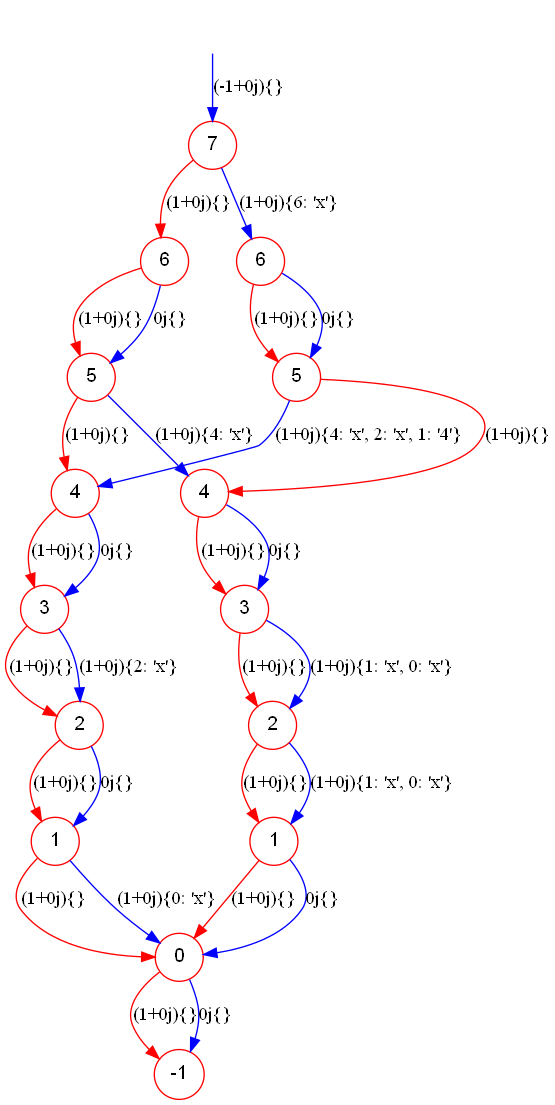

In [385]:
#当纠缠没有消掉的时候，1选择其他的方案消掉2，先处理别的比特
#当有分支的时候有两种情况，一种是两支只差一点点，加一个多比特门就能化回去
#另一个是最左边分支已经变成单位矩阵，其它分支需要加条件慢慢变过来
tdd_r,cir_head,cir_end=syn(tdd)
tdd_r = renormalize(tdd_r)
tdd_r.show(False)

In [302]:
# cir_head=QuantumCircuit(4)
# cir_head.x(0)
# cir_head.ccx(0,1,2)
# cir_head.x(0)
# cir_end=QuantumCircuit(4)
# tdd_r2 = update_tdd(tdd_r,cir_head,cir_end)
# tdd_r2.show(False)

New Qubits: 2
{-1: -1, 0: 'y1', 1: 'x1', 2: 'y0', 3: 'x0'}
{-1: -1, 'y1': 0, 'x1': 1, 'y0': 2, 'x0': 3}
{0: 2, 1: 2, 2: 2, 3: 2}
('x0', 0)
('y0', 0)
('x1', 0)
('y1', 0)
0  of  1


C:\Users\23626\AppData\Local\Temp\ipykernel_14860\4161480495.py:471: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  new_qubits.append(k.index+add_qubits_num)


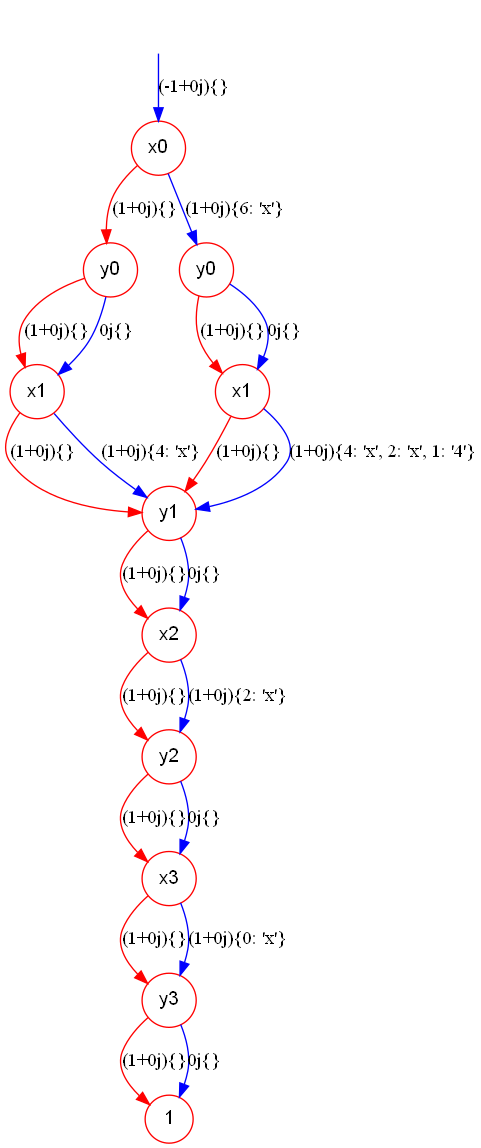

In [386]:
tdd_r_n=get_sub_dd(tdd_r,[0,0,1,0])
# tdd_r_n.show()
tdd_r_n,cir_head,cir_end=syn(tdd_r_n)
# tdd_r = renormalize(tdd_r)
# tdd_r_n.show(False)
cir_head2=get_controlled_circuit(cir_head,[0,1])
cir_end2=get_controlled_circuit(cir_end,[0,1])
tttt=update_tdd(tdd_r,cir_head2,cir_end2)
# tttt.show()
cir_head3=get_controlled_circuit(cir_head,[1,0])
cir_end3=get_controlled_circuit(cir_end,[1,0])
tttt=update_tdd(tttt,cir_head3,cir_end3)
tttt=renormalize(tttt)
tttt.show()

C:\Users\23626\AppData\Local\Temp\ipykernel_14860\4161480495.py:471: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  new_qubits.append(k.index+add_qubits_num)


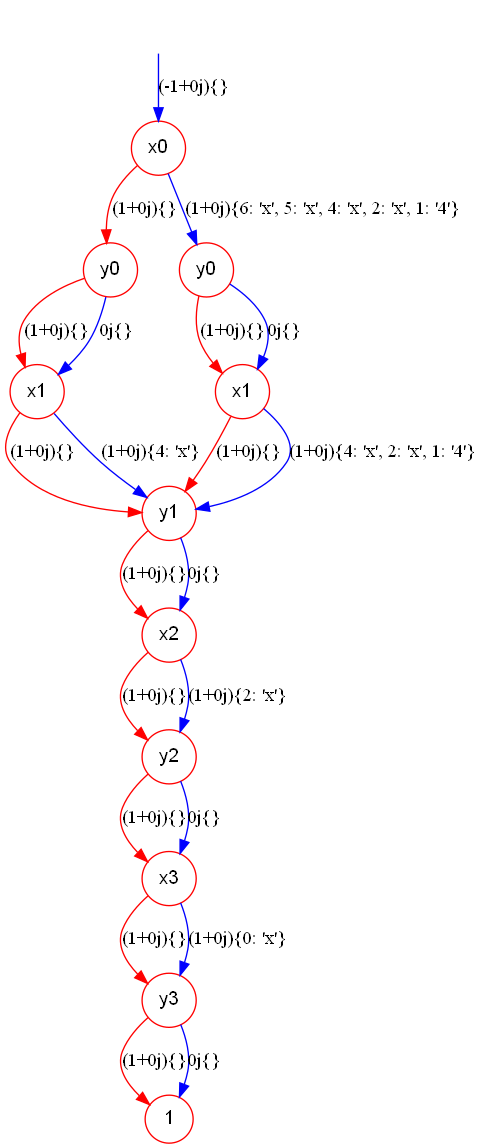

In [380]:

# tttt.show()
tdd_r_n2=get_sub_dd(tttt,[1,0])
# tdd_r_n.show()
tdd_r_n2,cir_head,cir_end=syn(tdd_r_n2)
# tdd_r = renormalize(tdd_r)
tdd_r_n2.show(False)

C:\Users\23626\AppData\Local\Temp\ipykernel_14860\4161480495.py:471: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  new_qubits.append(k.index+add_qubits_num)


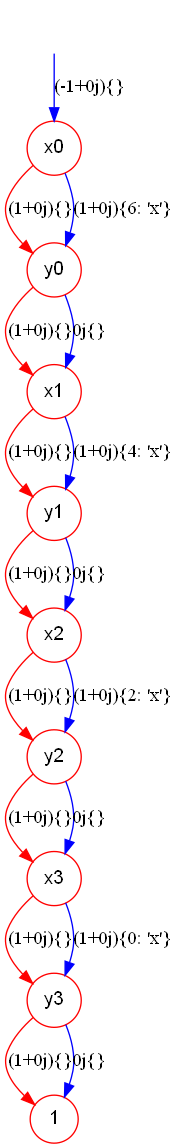

In [384]:
cir_head4=get_controlled_circuit(cir_head,[1])
cir_end4=get_controlled_circuit(cir_end,[1])
tttt=update_tdd(tttt,cir_head4,cir_end4)
tttt.show()